<a href="https://colab.research.google.com/github/ikennedy240/text4demog/blob/master/text4demog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis for Demography
*Ian Kennedy*  
University of Washington


Make sure you have data access¶

Great! Next, I reccomend connecting to your google drive. As long as the shared google drive folder text4demog is in your main gdrive folder by adding a link to the shared folder to your main drive, the rest of the code should run as written.

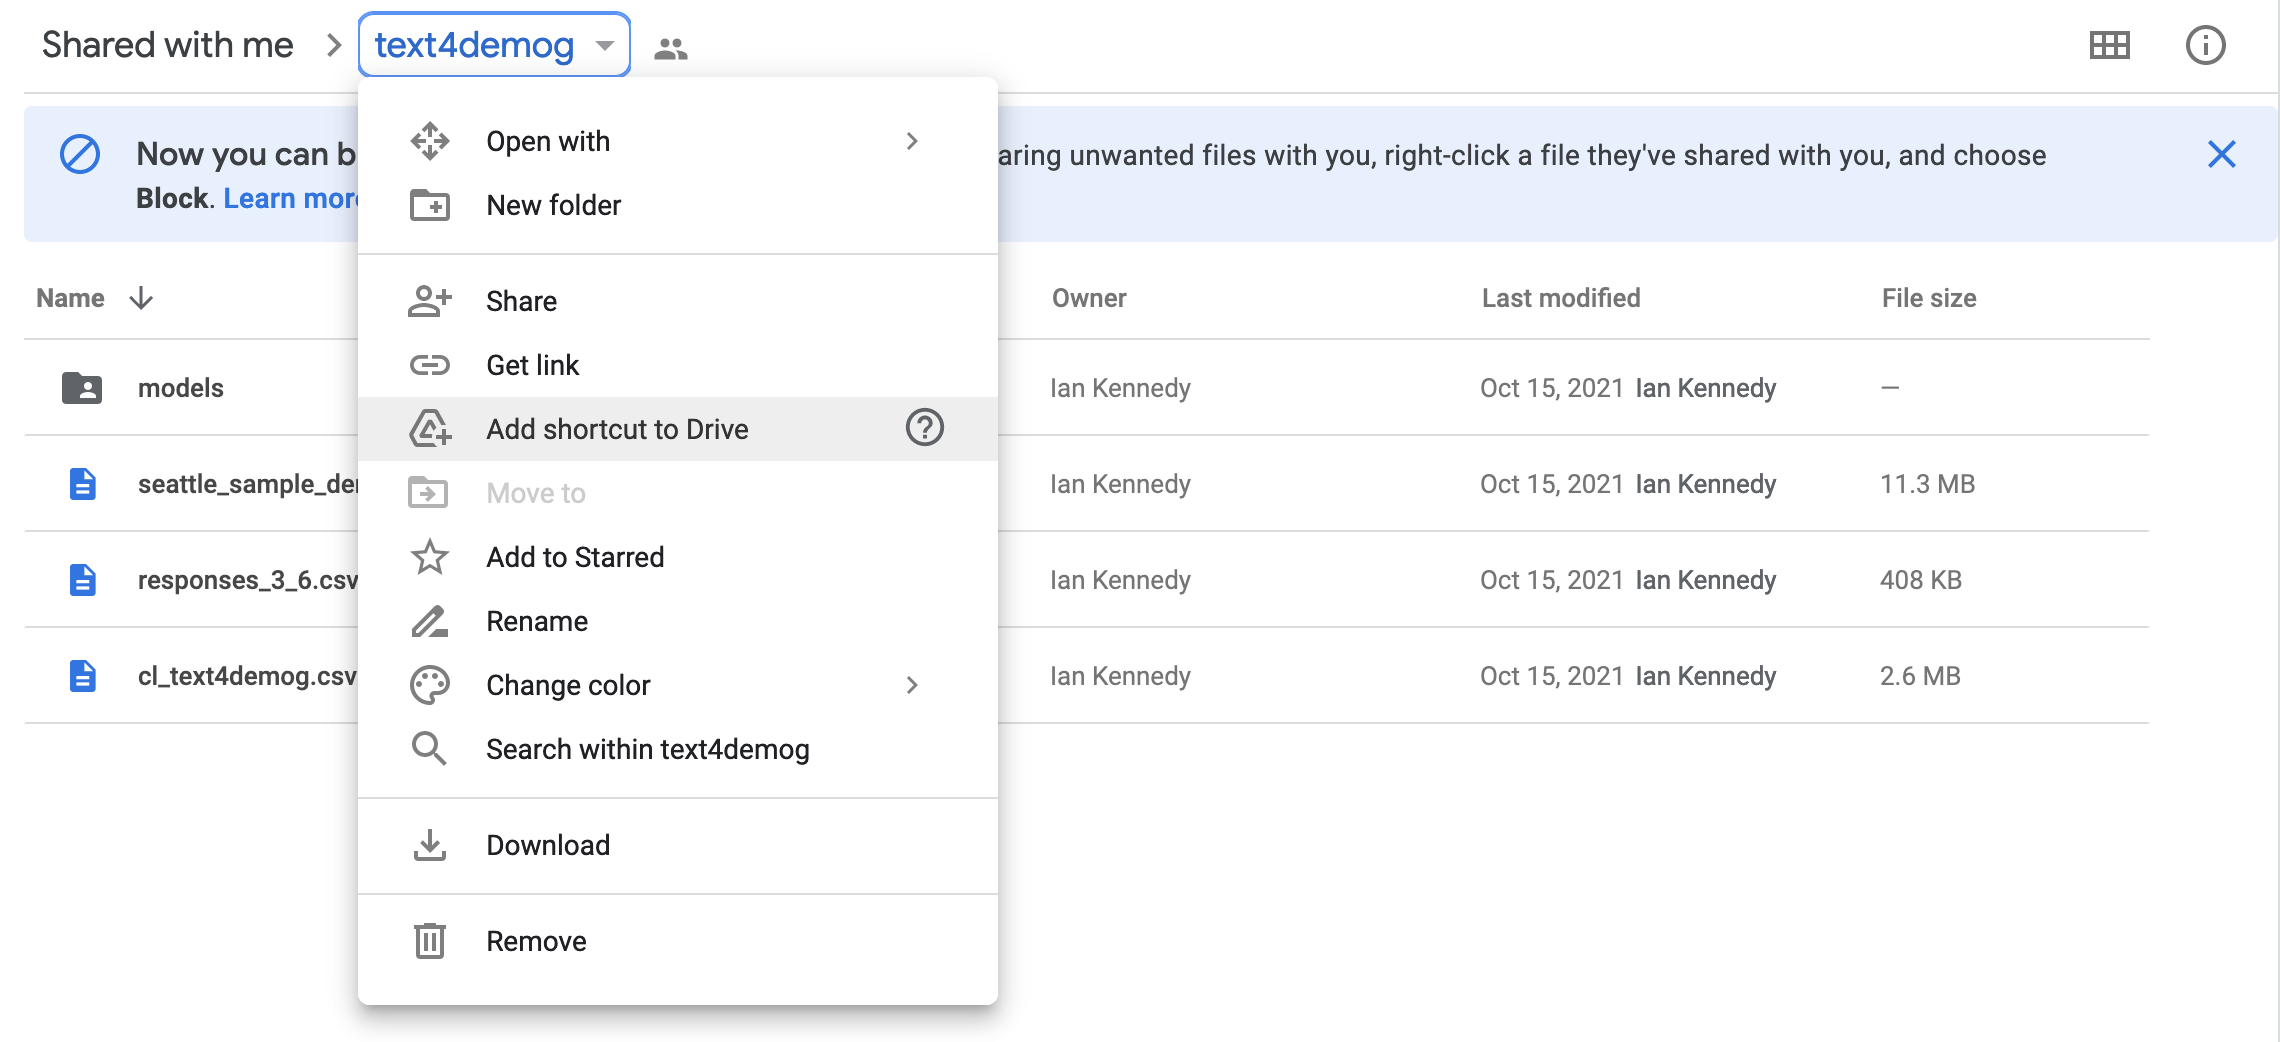

To mount your gogole drive, go to the 'files' pane on the left, and click the folder with the drive logo (far right). Then follow the instructions.

You can also copy the following code into a chunck and run it:
```
from google.colab import drive

drive.mount(‘/content/gdrive’)
```
Then you can test to see if you have access to the text4demog folder by running os.listdir('/content/drive/MyDrive/text4demog')

Alternatively, you could upload the data to google colab, but then just alter the data_path value below.


This notebook works through a couple python examples of text analysis using a small set of scraped craigslist data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
%matplotlib inline

In [ ]:
# we read the csv data
df = pd.read_csv('/content/drive/MyDrive/text4demog/seattle_sample_demog.csv',index_col=0,dtype = {'GEOID10':object,'blockid':object, 'postID':object})
df['high_white'] = df.white_proportion > np.median(df.white_proportion)

# then look at it, seems like a lot of fields
df.head()

,cleanRent,cleanSqft,cleanBeds,lat,lng,GEOID10,seattle,listingTitle,listingText,cleanText,neighborhood_type,white_proportion,black_proportion,aindian_proportion,asian_proportion,pacisland_proportion,other_proportion,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
postID,,,,,,,,,,,,,,,,,,,,,,,,,,,
post id: 6571302181,1900,1536,3,47.506616,-122.515246,53035092704,0.0,"3 Bd, 2 Bath home 1 mile from Southworth Ferry!",\nDesirable Southworth area 3 bedroom 2 full b...,3 bd 2 bath home 1 mile from southworth ferry ...,predominantly white,0.908531,0.002772,0.002772,0.007083,0.000000,0.034801,0.044041,0.037573,0.066523,3.247,0.796339,0.000000,0.020595,0.314136,0.130274,True
post id: 6604373845,1000,575,1,47.154868,-122.466552,53053071706,0.0,Looking for immediate move in? We got the 1 be...,\nFrom your first look you will be captivated ...,looking for immediate move in we got the 1 bed...,white mixed,0.508395,0.158972,0.000000,0.014690,0.121721,0.069255,0.122770,0.190976,0.162644,1.906,0.287779,0.106439,0.019711,0.396118,0.099161,False
post id: 6294456525,2000,982,2,47.703510,-122.346820,53033001300,1.0,Newer & Spacious 2 BR/1.5 bath w/attached 1 ca...,\r\nNewer with modern design in desirable Gree...,newer spacious 2 br 1 5 bath w attached 1 car ...,white asian,0.594545,0.050882,0.000000,0.221636,0.000000,0.055237,0.077699,0.055237,0.111850,4.363,0.427978,0.241921,0.011080,0.385056,0.266331,False
post id: 6489736188,2295,975,2,47.618820,-122.322040,53033007402,1.0,2 bd 1 ba Spacious True Capitol Hill Apt.,\nAWESOME APARTMENT ALERT! We are moving out o...,2 bd 1 ba spacious true apt awesome apartment ...,white asian,0.670378,0.061508,0.000000,0.126118,0.002555,0.078664,0.056032,0.081219,0.184158,5.479,0.204895,0.579112,0.015083,0.187991,0.281621,False
post id: 6072824373,2450,2650,4,47.482660,-122.192580,53033025601,0.0,"$2450 / 4br-2650sqft - Lake+City View House, R...","\r\nSpectacular view of Lake Washington, Seatt...",$2450 4br 2650sqft lake city view house great ...,mixed,0.370931,0.048070,0.000000,0.293149,0.031226,0.051665,0.188872,0.082892,0.112633,5.284,0.624315,0.254609,0.004484,0.418244,0.154996,False


Ok, this gives us a pandas data frame with 5000 observations, each a *Craigslist* listing with the text, some meta-data (like the geocoded location and tract id), the listing title and text, a cleaned version of those, and some tract-level covariates. We're going to be looking at how the listing text varies with some of those covariates.

We'll start at the word level, move over to R for some document level work, and then back here for some word embeddings if we have time.

## Word Level Analysis

Perhpas the simplist way of looking into the texts is to do some keyword analysis. If we already know what we're looking for, we can pull out some interesting things. For instance, we can see the difference in means for listings that have the word 'hardwood' or not:

In [ ]:
df.groupby(df.cleanText.str.contains("hardwood")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,pacisland_proportion,other_proportion,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,,
False,1902.646470,1121.287144,2.001581,47.572678,-122.321826,0.393883,0.655345,0.050444,0.006266,0.138964,0.006077,0.054142,0.086702,0.066485,0.126039,5.737086,0.495376,0.197384,0.029308,0.341920,0.216911,0.478398
True,2363.681894,1410.066445,2.368771,47.594714,-122.314008,0.518703,0.682694,0.042924,0.005585,0.136364,0.004580,0.052155,0.073697,0.062319,0.112182,5.753631,0.507072,0.201123,0.028770,0.338721,0.246290,0.566445


In [ ]:
df.groupby(df.cleanText.str.contains("luxury")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,pacisland_proportion,other_proportion,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,,
False,1993.146082,1192.842842,2.101776,47.576990,-122.319836,0.419699,0.661945,0.048615,0.006127,0.137769,0.005822,0.053756,0.083940,0.065705,0.122512,5.732103,0.502730,0.191838,0.028178,0.342332,0.222478,0.500940
True,2470.302326,1145.920930,1.827907,47.600113,-122.322337,0.518692,0.661599,0.049042,0.005556,0.151010,0.003363,0.051602,0.075357,0.060521,0.126942,5.940642,0.397205,0.341760,0.051428,0.314820,0.257552,0.469767


In [ ]:
df.groupby(df.cleanText.str.contains("patrol")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,pacisland_proportion,other_proportion,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,,
False,2015.979456,1193.261027,2.094058,47.578545,-122.320038,0.425116,0.662693,0.048471,0.006099,0.138150,0.005673,0.053630,0.083241,0.065402,0.122457,5.740122,0.498813,0.198001,0.029160,0.341031,0.224257,0.500906
True,1685.171429,845.285714,1.514286,47.498462,-122.306481,0.257143,0.553728,0.071582,0.006540,0.165003,0.011933,0.058335,0.130396,0.076808,0.157491,5.875600,0.410242,0.238567,0.031736,0.357989,0.185493,0.314286


In [ ]:
df.groupby(df.cleanText.str.contains("light rail")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,pacisland_proportion,other_proportion,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,,
False,2009.610169,1199.666667,2.107135,47.577403,-122.320529,0.403979,0.666352,0.046168,0.006101,0.136751,0.005701,0.053471,0.083430,0.065273,0.120048,5.746297,0.504247,0.192791,0.028806,0.344672,0.223077,0.504708
True,2101.321267,999.633484,1.719457,47.590546,-122.307283,0.855204,0.566307,0.101929,0.006123,0.172650,0.006045,0.057822,0.086603,0.069990,0.180095,5.628041,0.367275,0.317074,0.037223,0.264977,0.243632,0.389140


### Tokenization
To get more detailed, we'll need to tokenize the text

In [ ]:
# get stop words and compile into regex
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*', flags=re.IGNORECASE)

X = [[word for word in pattern.sub('', document.lower()).split() if len(word)>3] for document in df.cleanText.values]
X = [' '.join(x) for x in X]

# form train test split
from sklearn.model_selection import train_test_split

# this is important because it's where we set our outcome variable: above median white proportion
X_train, X_test, y_train, y_test = train_test_split(X, df['high_white'], random_state=0)

# look at the first item in train
X_train[1]

'stunner 18th floor view square feet spacious studio amazing views washington state ferries centurylink stadium beauty cozy spacious plenty closet space modern appliances plenty room make studio home brand interiors include plank flooring stainless appliances quartz counter tops'

### Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Fit the CountVectorizer to the training data
vect = CountVectorizer(stop_words=stop_words).fit(X_train)
print("Total Features: ", len(vect.get_feature_names()))
X_train_vectorized =  vect.transform(X_train)

Total Features:  13281


### Word Level Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
model = LogisticRegression(penalty = 'none',C=.1).fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict_proba(vect.transform(X_test))[:,1]
print("ROC AUC: ", roc_auc_score(y_test, predictions))
print("ACCURACY: ", accuracy_score(y_test, model.predict(vect.transform(X_test))))
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())
# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


ROC AUC:  0.7000473630312339
ACCURACY:  0.6536


Considering that it's binary, that's not a great result, but we're not really here for the accuracy, we're interested in the features.

In [ ]:
# Find the 20 smallest and 20 largest coefficients
# The 20 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['airport' 'concierge' '98144' 'seward' 'rich' 'westwood' '98109'
 'picture' 'intercom' 'furnishings' '98052' 'type' 'sculpture' 'student'
 'john' 'thursday' 'stackable' 'cabana' '98037' 'evenings']

Largest Coefs: 
['psns' 'getting' 'septic' 'nordstrom' 'salmon' 'meet' 'cooling' '98102'
 'lined' 'woodland' '98033' 'eviction' 'hold' 'marina' 'children' 'bridge'
 '98119' 'junction' '98115' 'ferry']


We can try using ngram features

In [ ]:
vect = CountVectorizer(stop_words=stop_words,ngram_range=(1,4)).fit(X_train)
print("Total Features: ", len(vect.get_feature_names()))
X_train_vectorized =  vect.transform(X_train)
model = LogisticRegression(penalty = 'none',C=.1).fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict_proba(vect.transform(X_test))[:,1]
print("ROC AUC: ", roc_auc_score(y_test, predictions))
print("ACCURACY: ", accuracy_score(y_test, model.predict(vect.transform(X_test))))
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())
# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Total Features:  699875


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


ROC AUC:  0.7384037378392216
ACCURACY:  0.6632
Smallest Coefs:
['microsoft' 'airport' 'mall' 'center' 'offers' 'college' 'shopping'
 'rail' 'light rail' 'campus' 'station' 'breakfast' 'town center'
 'concierge' 'come' 'townhouse' 'south' 'email' 'reserved' 'want']

Largest Coefs: 
['best' 'main floor' 'children' 'marina' '98115' 'junction' 'sunny'
 'high ceilings' 'friendly' 'approximately' 'heart' 'ceilings' 'sound'
 'charming' 'building' 'restaurants' 'bike' 'ferry' 'beach' 'market']


We don't see much improvement even though we have many many more features. That's partially because this data set is so small. Still, many of these words are similar to what I see when I run this analysis on the full set of data.


### Naive Bayes on Twitter Data

In [ ]:
tweets = pd.read_csv('/content/drive/MyDrive/text4demog/responses_3_6.csv')

In [ ]:
tweets['racist'] = tweets.valence.str.contains("Racist", na = False)
tweets['empowering'] = tweets.valence.str.contains("Empowering", na = False)
tweets['antiracist'] = tweets.valence.str.contains("Anti", na = False)

In [ ]:
X = [[word for word in pattern.sub('', document.lower()).split() if len(word)>3] for document in tweets.text.values]
X = [' '.join(x) for x in X]

# form train test split
# this is important because it's where we set our outcome variable: 
X_train, X_test, y_train, y_test = train_test_split(X, tweets['racist'], random_state=0)

# look at the first item in train
print("Tweet:",X_train[0],"\n\n Marked as Empowering:", y_train.iloc[0])

Tweet: @sherrishultz @dergholt @the_moviebob (actual) racism systemic. <u+2019>s ideology exists maintain white dominance people color 

 Marked as Empowering: True


In [ ]:
from sklearn.naive_bayes import MultinomialNB
# lets just use 1 and 2 grams
vect = CountVectorizer(stop_words=stop_words,ngram_range=(1,2)).fit(X_train)
print("Total Features: ", len(vect.get_feature_names()))
X_train_vectorized =  vect.transform(X_train)

Total Features:  3283


In [ ]:
model = MultinomialNB().fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict_proba(vect.transform(X_test))[:,1]
print("ROC AUC: ", roc_auc_score(y_test, predictions))
print("ACCURACY: ", accuracy_score(y_test, model.predict(vect.transform(X_test))))
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())
# Sort the posterior probabilities from the model
sorted_coef_index = model.feature_log_prob_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

ROC AUC:  0.7616738816738816
ACCURACY:  0.7222222222222222
Smallest Coefs:
['zionist blacks' 'murder' 'multitude experiences' 'multitude'
 'com dunkin' 'movie true' 'movie' 'mouth white' 'mouth' 'comes'
 'commandant' 'commandant following' 'murder look' 'mother lobby'
 'comment saying' 'commenting' 'commenting issues' 'moron bitch' 'moron'
 'monkey lose']

Largest Coefs: 
['magic' 'love black' 'know' 'time' 'love' 'american' 'black people'
 'black girl' 'girl' 'black women' 'like' 'white' 'just' 'women'
 'africanamerican' 'don' '2019' 'people' 'https' 'black']


## Word Embeddings with Gensim word2vec

In [ ]:
import logging
import os
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.stem import PorterStemmer
# gensim can hang sometimes so it's good to use this logger esp. in notebook
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# class for reading gensim stuff
class MySentences(object):
    def __init__(self, document):
        self.document = document

    def __iter__(self):
        ps = PorterStemmer()
        punctuation_pattern = r"[#\w]+|[!?]+" # compile a regex that saves certain characters
        url_pattern = r'(http)?(www)?\S*(\.com|\.net|\.gov|\.be|\.org)\S*'
        short_pattern = r"(^| |')\b\w{1,3}\b"
        for line in self.document:
            line = re.sub(url_pattern,' its_a_URL ', line.lower()) # clean URLS
            line = re.sub(r'\s\w*\d+\w*\s', ' its_a_number ', line)  # clean Numbers
            #line = re.sub(short_pattern, ' ', line)
            line = re.sub(r'\W',' ',line)
            line = re.sub(r'queen anne', 'queen_anne', line)
            line = re.sub(r'(u district)|(university district)', 'university_district', line)
            line = re.sub(r'courtesy patrol', 'courtesy_patrol', line)
            line = re.sub(r'gated community', 'gated_community', line)
            yield [ps.stem(x) for x in line.split()]

In [ ]:

def display_keywords_PCAscatterplot(model, word, ref = False, key_words = None, fig = None, ax = None, title=None):

    arr = np.empty((0,100), dtype='f')
    word_labels = [word]
    word_vectors = model.wv

    # if there are no keywords, get the closest 20 from the model
    if key_words is None:
        key_words = [x[0] for x in word_vectors.similar_by_word(word, topn = 7)]

    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([word_vectors[word]]), axis=0)
    for key_word in key_words:
        try:
            wrd_vector = word_vectors[key_word]
        except KeyError:
            print("KeyError: "+key_word+" not in this model")
            continue
        word_labels.append(key_word)
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    pca = PCA(n_components=2)
    result = pca.fit_transform(arr)
    # create a scatter plot of the projection
    if fig is None:
        fig, ax = plt.subplots(figsize = (12.8,9.6))
    if ref:
        ax.scatter(result[:, 0], result[:, 1], c = 'r')
        display_keywords_PCAscatterplot(models['sent_tokenized.txt'], word = word, key_words=  key_words, fig = fig, ax = ax)
    if not ref:
        ax.scatter(result[:, 0], result[:, 1], c = 'b')
    for i, word in enumerate(word_labels):
        ax.annotate(word, xy=(result[i, 0]+.04, result[i, 1]+.04), fontsize = 16)
    ax.set_title(title)
    print(word_labels)
    #return fig

In [ ]:
# this chunk takes aprox 2mins to run

# pass the text file to the sentence iterator
sentences = MySentences(df.cleanText) # a memory-friendly iterator

# train the w2v model
model = Word2Vec(sentences, workers = 2)
word_vectors = model.wv

2021-10-15 20:20:54,730 : INFO : collecting all words and their counts
2021-10-15 20:20:54,742 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-15 20:21:13,769 : INFO : collected 11089 word types from a corpus of 835765 raw words and 5000 sentences
2021-10-15 20:21:13,771 : INFO : Loading a fresh vocabulary
2021-10-15 20:21:13,788 : INFO : effective_min_count=5 retains 3943 unique words (35% of original 11089, drops 7146)
2021-10-15 20:21:13,790 : INFO : effective_min_count=5 leaves 823999 word corpus (98% of original 835765, drops 11766)
2021-10-15 20:21:13,808 : INFO : deleting the raw counts dictionary of 11089 items
2021-10-15 20:21:13,810 : INFO : sample=0.001 downsamples 63 most-common words
2021-10-15 20:21:13,812 : INFO : downsampling leaves estimated 626916 word corpus (76.1% of prior 823999)
2021-10-15 20:21:13,829 : INFO : estimated required memory for 3943 words and 100 dimensions: 5125900 bytes
2021-10-15 20:21:13,831 : INFO : resetting la

2021-10-15 20:27:06,806 : INFO : precomputing L2-norms of word weight vectors


['starbuck', 'safeway', 'qfc', 'meyer', 'fred', 'bartel', 'walmart', 'pcc']


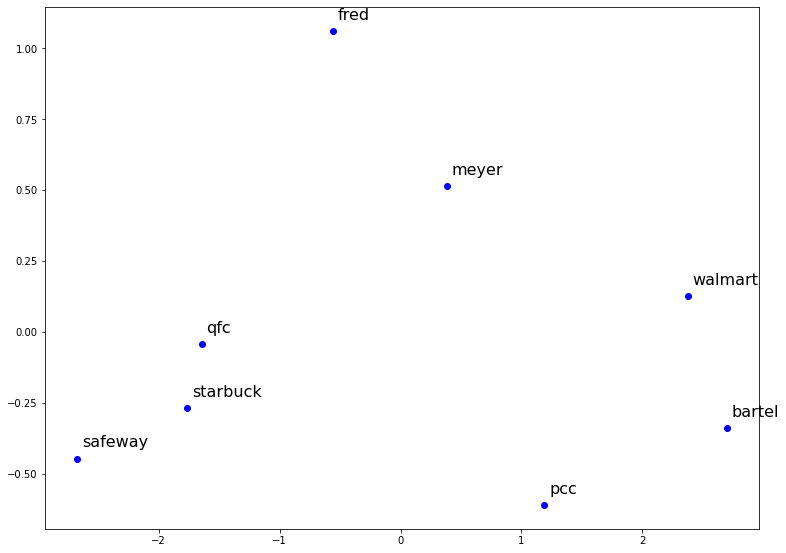

In [ ]:
display_keywords_PCAscatterplot(model, 'starbuck')

['gated_commun', 'townhom', 'condominium', '2ba', 'stori', 'hollow', 'craftsman', 'execut']


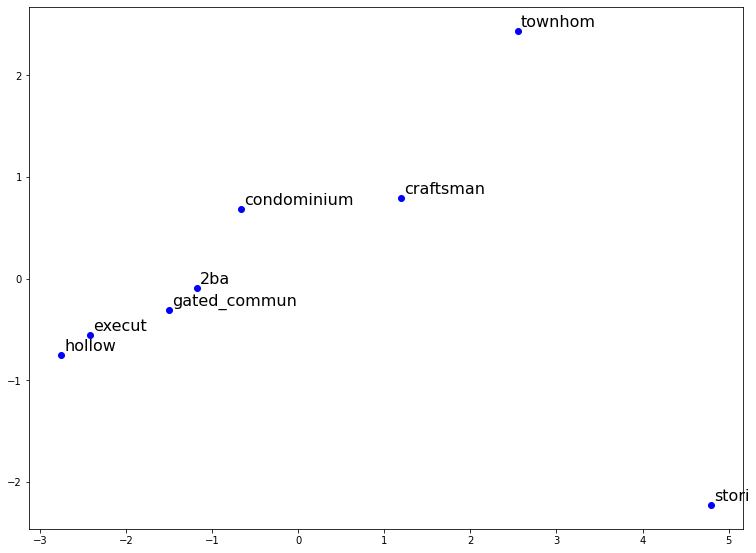

In [ ]:
display_keywords_PCAscatterplot(model, 'gated_commun')

['crimin', 'convict', 'histori', 'refer', 'neg', 'evict', 'record', 'verif']


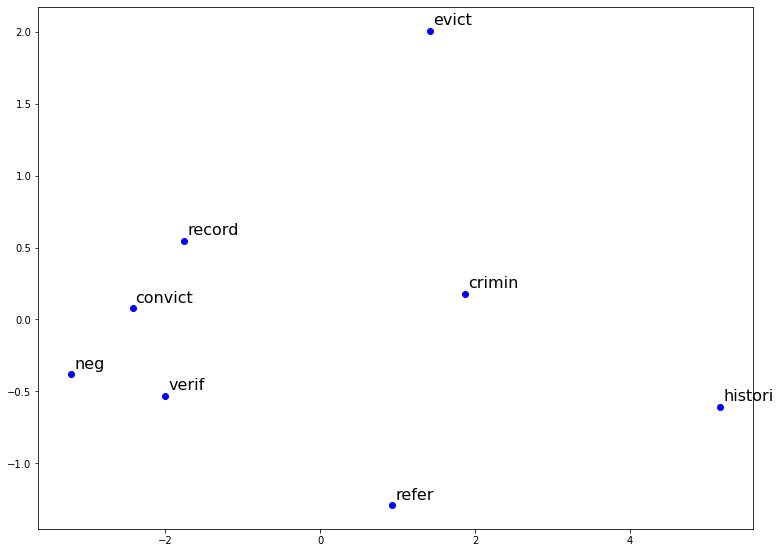

In [ ]:
display_keywords_PCAscatterplot(model, 'crimin')